In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import talib

In [2]:
df = pd.read_csv('D:/EURUSD.csv', names=['Date', 'Time', 'Open', 'High', 'Low', 'Close', 'Volume'])

In [3]:
df.set_index(pd.to_datetime(df.Date+" "+df.Time), inplace=True)

In [4]:
def priceMoveCount(x, dx):
    nUP = nDown = 0
    x_ext = x[0]
    if dx<0: return
    ret = np.array([[0,0]])
    for i in range(1, x.shape[0]):
        if (x[i]-x_ext) >= dx:
            nUP+=1
            x_ext = x[i]
        elif (x[i]-x_ext) <= -dx:
            nDown += 1
            x_ext = x[i]
        ret=np.append(ret,[[nUP,nDown]], axis=0)
    return ret
        

In [5]:
def directionalChangeCount(x, r):
    nUP = nDown = 0
    x_ext = x[0]
    mode = 0
    
    ret =[[0,0,mode,r]]
    for i in range(1, x.shape[0]):
        if mode==1:
            if x[i]<x_ext:
                x_ext = x[i]
            elif x[i]-x_ext >= r:
                nUP += 1
                x_ext = x[i]
                mode = 0
        elif mode==0:
            if x[i]>x_ext:
                x_ext = x[i]
            elif x[i]-x_ext <= -r:
                nDown += 1
                x_ext = x[i]
                mode = 1
        ret = np.append(ret, [[nUP,nDown,mode,r]], axis=0)
    return ret

In [6]:
raw = df.resample("60T").agg({"Open":"first","High":"max","Low":"min","Close":"last"}).copy()

In [7]:
raw=raw.ffill()

In [8]:
raw.dropna(inplace=True)

In [9]:
raw=raw.loc['2014-01-01':]

In [10]:
raw=raw.iloc[-350*251:]

In [11]:
ret=dict()
new_df=dict()
for r in np.linspace(0.001, 0.02, num=500):
    ndc={}
    ndc_list=[]
    for n in range(1,int(raw.shape[0]/350)+1):
        test_sample = raw.iloc[(n-1)*350:n*350]
        res=directionalChangeCount(test_sample.Close.values, r)
        ndc.update({n:res[-1][0]+res[-1][1]})
        ndc_list.append(res[-1][0]+res[-1][1])
    ret.update({r:{'avgndc': np.mean(ndc_list), 'NDC':ndc}})
    # new_df.update({r:pd.DataFrame(res, columns=["UP","DOWN","MODE","ATR"])})

In [12]:
vol=np.array([])

group=np.array([])

In [13]:
for n in range(1,int(raw.shape[0]/350)+1):
    test_sample = raw.iloc[(n-1)*350:n*350]
    vol=np.concatenate([vol,np.repeat(np.sum(np.abs(np.diff(np.log(test_sample.Close))))/350,350)])
    group=np.concatenate([group,np.repeat(n,350)])

In [14]:
# raw=raw.iloc[:-(raw.shape[0]-vol.shape[0])]

In [15]:
raw['vol']=vol

In [16]:
raw['group']=group

In [17]:
x=list(ret.keys())

In [18]:
y=[np.log(ret[i]['avgndc']) for i in list(ret.keys())]

In [19]:
import statsmodels.api as sm

In [20]:
x=np.log(np.array(x))
# x=np.concatenate([[x],[np.power(x,2)]]).T
x_1 = sm.add_constant(x)
mod = sm.OLS(y, x_1)

In [21]:
res=mod.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.985
Model:                            OLS   Adj. R-squared:                  0.985
Method:                 Least Squares   F-statistic:                 3.228e+04
Date:                Sun, 11 Feb 2024   Prob (F-statistic):               0.00
Time:                        11:14:56   Log-Likelihood:                 271.17
No. Observations:                 500   AIC:                            -538.3
Df Residuals:                     498   BIC:                            -529.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -6.7221      0.043   -157.922      0.000      -6.806      -6.638
x1            -1.5903      0.009   -179.656      0.000      -1.608      -1.573
==============================================================================
Omnibus:                       52.333   Durbin-Watson:                   0.002
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               66.999
Skew:                          -0.894   Prob(JB):                     2.83e-15
Kurtosis:                       3.134   Cond. No.                         33.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

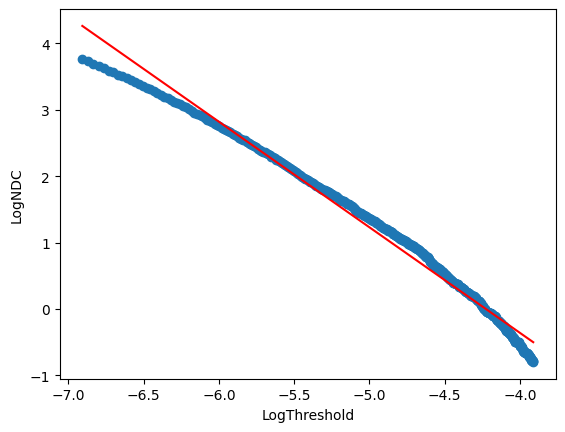

In [22]:
plt.scatter(x, y)
# x1= [np.log(i[0]) for i in x]
slope_y = x*res.params[1]+res.params[0]
# plt.scatter(x=[i[0] for i in x], y=slope_y)
plt.plot(x, slope_y, color='red')
plt.xlabel('LogThreshold')
plt.ylabel('LogNDC')
plt.savefig('THRES_NDC.png')

In [23]:
res.save("NDCThreshold_Original.pickle")

In [24]:
keys = list(ret.keys())

In [25]:
avg_ret_list=[]
avg_ret_dict={}
for k in keys: 
    keyss=[]
    values=[]
    for i in list(ret[k]['NDC'].keys()):
        avg=[]
        vol=[]
        ret_dict={}
        ex=[]
        ndc=ret[k]['NDC'][i]
        try:
            seg=int(350/ndc)
        except OverflowError:
            continue
        length=int(round(350/seg,0))
    
        for j in range(1,length+1):
            try:
                xa=abs(np.log(raw.loc[raw.group==i].iloc[(j-1)*seg].Close)-np.log(raw.loc[raw.group==i].iloc[j*seg].Close))
            except IndexError:
                break
            if xa==0 or vol==-np.inf:
                continue
            avg.extend([xa])
        xv=raw.loc[raw.group==i].vol.mean()
        vol.extend([xv])
        keyss.append(i)
        values.append({'return':np.asarray(avg).mean(), 'vol':np.asarray(vol).mean(), 'seg':seg, 'ndc':ret[k]['avgndc'], 'sample_ndc':ndc})
        # ret_dict[i]={'return':np.asarray(avg).mean(), 'vol':np.asarray(vol).mean(), 'seg':seg, 'ndc':ret[k]['avgndc']}
    avg_ret_list.append(dict(zip(keyss,values)))
avg_ret_dict=dict(zip(keys, avg_ret_list))

C:\Users\zekec\AppData\Local\Temp\ipykernel_9524\1778888863.py:29: RuntimeWarning: Mean of empty slice.
  values.append({'return':np.asarray(avg).mean(), 'vol':np.asarray(vol).mean(), 'seg':seg, 'ndc':ret[k]['avgndc'], 'sample_ndc':ndc})
D:\anaconda3\envs\quant\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\zekec\AppData\Local\Temp\ipykernel_9524\1778888863.py:13: RuntimeWarning: divide by zero encountered in scalar divide
  seg=int(350/ndc)


# 1st Order

In [26]:
avgs=[]
for k in list(avg_ret_dict.keys()):
    x=np.asarray([avg_ret_dict[k][i]['return'] for i in list(avg_ret_dict[k])])
    avgs.append(np.mean(x[~np.isnan(x)]))

In [27]:
avg_seg = dict(zip(list(avg_ret_dict.keys()), avgs))

In [28]:
ret_seg=pd.DataFrame.from_dict(avg_seg, orient='index', columns=['ret'])

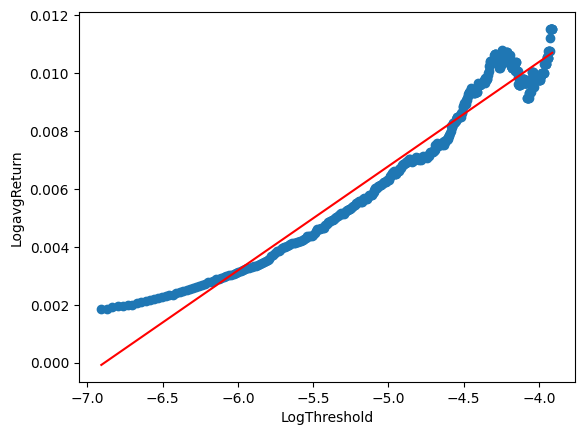

In [29]:
x=np.log(ret_seg.index)
y=ret_seg.values
plt.scatter(x,y)

x_1 = sm.add_constant(x)
mod = sm.OLS(y, x_1)
res=mod.fit()
x_scatter = x
y_scatter = x*res.params[1]+res.params[0]
plt.plot(x_scatter,y_scatter, color='red')
plt.xlabel('LogThreshold')
plt.ylabel('LogavgReturn')
plt.savefig('THRES_RET.png')

In [30]:
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.946
Model:                            OLS   Adj. R-squared:                  0.946
Method:                 Least Squares   F-statistic:                     8738.
Date:                Sun, 11 Feb 2024   Prob (F-statistic):          5.93e-318
Time:                        11:27:33   Log-Likelihood:                 2990.1
No. Observations:                 500   AIC:                            -5976.
Df Residuals:                     498   BIC:                            -5968.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0248      0.000    133.849      0.000       0.024       0.025
x1             0.0036   3.85e-05     93.476      0.000       0.004       0.004
==============================================================================
Omnibus:                       52.196   Durbin-Watson:                   0.017
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               59.685
Skew:                           0.811   Prob(JB):                     1.10e-13
Kurtosis:                       2.517   Cond. No.                         33.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [31]:
res.save("RETThreshold_Original.pickle")

In [32]:
vol_ret={}
for k in list(avg_ret_dict.keys()):
    x=np.asarray([avg_ret_dict[k][i]['return'] for i in list(avg_ret_dict[k])])
    y=np.asarray([avg_ret_dict[k][i]['vol'] for i in list(avg_ret_dict[k])])
    idx=np.argwhere(~np.isnan(x)).flatten()
    vol_ret.update({k:{'ret':np.mean(x[idx]),'vol':np.mean(y[idx])}}) #.append(np.mean(x[~np.isnan(x)]))

In [33]:
vol_ret_df=pd.DataFrame.from_dict(vol_ret, orient='index')

C:\Users\zekec\AppData\Local\Temp\ipykernel_9524\1369721457.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_scatter = x*res.params[1]+res.params[0]


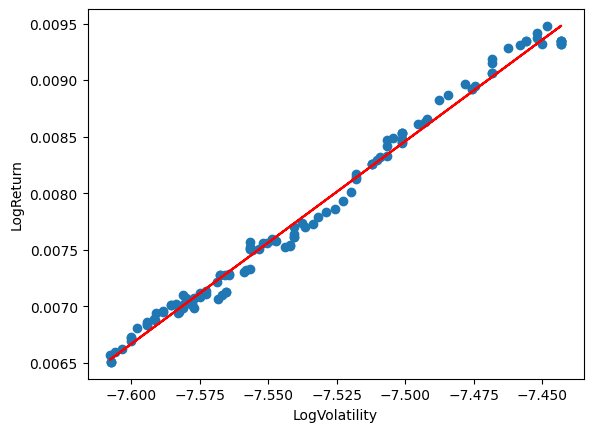

In [34]:
s=0.007
e=0.012
y=vol_ret_df.loc[(vol_ret_df.index>s)&(vol_ret_df.index<e)]['ret']
x=vol_ret_df.loc[(vol_ret_df.index>s)&(vol_ret_df.index<e)]['vol']
# x=[j for i in np.array(x).flatten() for j in i]
x=np.log(np.array(x))
# y=[j for i in np.array(y).flatten() for j in i]
plt.scatter(x,y)
x_1 = sm.add_constant(x)
mod = sm.OLS(y, x_1)
res=mod.fit()
x_scatter = x
y_scatter = x*res.params[1]+res.params[0]
plt.plot(x_scatter,y_scatter, color='red')
plt.xlabel('LogVolatility')
plt.ylabel('LogReturn')
plt.savefig('VOL_RET.png')

In [35]:
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    ret   R-squared:                       0.991
Model:                            OLS   Adj. R-squared:                  0.991
Method:                 Least Squares   F-statistic:                 1.396e+04
Date:                Sun, 11 Feb 2024   Prob (F-statistic):          2.37e-133
Time:                        11:27:34   Log-Likelihood:                 1044.4
No. Observations:                 131   AIC:                            -2085.
Df Residuals:                     129   BIC:                            -2079.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1429      0.001    124.962      0.000       0.141       0.145
x1             0.0179      0.000    118.158      0.000       0.018       0.018
==============================================================================
Omnibus:                        7.501   Durbin-Watson:                   0.336
Prob(Omnibus):                  0.024   Jarque-Bera (JB):                6.159
Skew:                          -0.435   Prob(JB):                       0.0460
Kurtosis:                       2.390   Cond. No.                     1.19e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.19e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [36]:
res.save("RETVOL_Original.pickle")

In [37]:
vol_ndc={}
for k in list(avg_ret_dict.keys()):
    x=np.asarray([avg_ret_dict[k][i]['sample_ndc'] for i in list(avg_ret_dict[k])])
    y=np.asarray([avg_ret_dict[k][i]['vol'] for i in list(avg_ret_dict[k])])
    idx=np.argwhere(~np.isnan(x)).flatten()
    vol_ndc.update({k:{'ndc':x[idx],'vol':y[idx]}}) #.append(np.mean(x[~np.isnan(x)]))

In [38]:
vol_ndc_df=pd.DataFrame.from_dict(vol_ndc, orient='index')

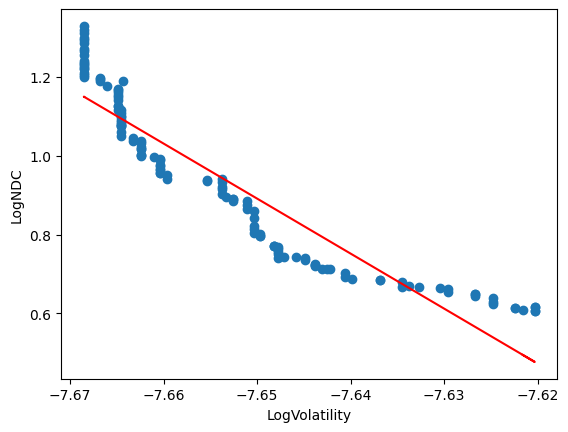

In [39]:
s=0.007
e=0.012
y=vol_ndc_df.loc[(vol_ndc_df.index>s)&(vol_ndc_df.index<e)]['ndc']
x=vol_ndc_df.loc[(vol_ndc_df.index>s)&(vol_ndc_df.index<e)]['vol']
x=[np.mean(i) for i in np.array(x)]
x=np.log(np.array(x))
y=[np.mean(i) for i in np.array(y)]
y=np.log(np.array(y))
plt.scatter(x,y)
x_1 = sm.add_constant(x)
mod = sm.OLS(y, x_1)
res=mod.fit()
x_scatter = x
y_scatter = x*res.params[1]+res.params[0]
plt.plot(x_scatter,y_scatter, color='red')
plt.xlabel('LogVolatility')
plt.ylabel('LogNDC')
plt.savefig('VOL_NDC.png')

In [40]:
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.871
Model:                            OLS   Adj. R-squared:                  0.870
Method:                 Least Squares   F-statistic:                     873.1
Date:                Sun, 11 Feb 2024   Prob (F-statistic):           2.81e-59
Time:                        11:27:34   Log-Likelihood:                 151.51
No. Observations:                 131   AIC:                            -299.0
Df Residuals:                     129   BIC:                            -293.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -105.7888      3.612    -29.290      0.000    -112.935     -98.643
x1           -13.9451      0.472    -29.549      0.000     -14.879     -13.011
==============================================================================
Omnibus:                       18.983   Durbin-Watson:                   0.029
Prob(Omnibus):                  0.000   Jarque-Bera (JB):                9.819
Skew:                           0.491   Prob(JB):                      0.00738
Kurtosis:                       2.086   Cond. No.                     4.20e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.2e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [41]:
res.save("NDCVOL_Original.pickle")

In [42]:
vol_thres={}
for k in list(avg_ret_dict.keys()):
    x=k
    y=np.asarray([avg_ret_dict[k][i]['vol'] for i in list(avg_ret_dict[k])])
    vol_thres.update({k:{'thres':x,'vol':np.mean(y)}}) #.append(np.mean(x[~np.isnan(x)]))

In [43]:
vol_thres_df=pd.DataFrame.from_dict(vol_thres, orient='index')

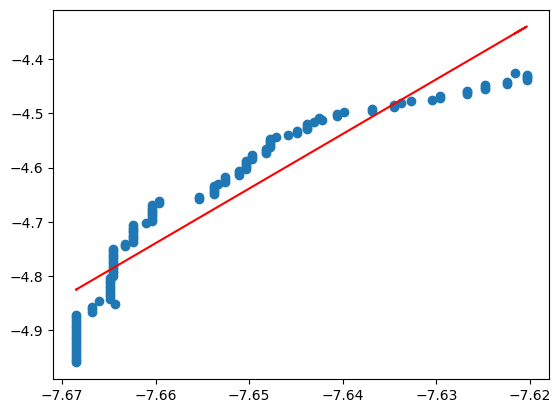

In [44]:
s=0.007
e=0.012
y=vol_thres_df.loc[(vol_thres_df.index>s)&(vol_thres_df.index<e)]['thres']
x=vol_thres_df.loc[(vol_thres_df.index>s)&(vol_thres_df.index<e)]['vol']
x=np.log(np.array(x))
y=np.log(np.array(y))
plt.scatter(x,y)
x_1 = sm.add_constant(x)
mod = sm.OLS(y, x_1)
res=mod.fit()
x_scatter = x
y_scatter = x*res.params[1]+res.params[0]
plt.plot(x_scatter,y_scatter, color='red')


In [45]:
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.860
Model:                            OLS   Adj. R-squared:                  0.859
Method:                 Least Squares   F-statistic:                     795.4
Date:                Sun, 11 Feb 2024   Prob (F-statistic):           5.16e-57
Time:                        11:27:35   Log-Likelihood:                 187.99
No. Observations:                 131   AIC:                            -372.0
Df Residuals:                     129   BIC:                            -366.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         72.4382      2.734     26.495      0.000      67.029      77.847
x1            10.0754      0.357     28.203      0.000       9.369      10.782
==============================================================================
Omnibus:                       25.705   Durbin-Watson:                   0.021
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               13.520
Skew:                          -0.619   Prob(JB):                      0.00116
Kurtosis:                       2.027   Cond. No.                     4.20e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.2e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [46]:
res.save("VOLThres_Original.pickle")

In [47]:
s=0.007
e=0.012
y=vol_ret_df.loc[(vol_ret_df.index>s)&(vol_ret_df.index<e)]['ret']
x1=np.log(vol_ret_df.loc[(vol_ret_df.index>s)&(vol_ret_df.index<e)].index)
x2=np.log(vol_ret_df.loc[(vol_ret_df.index>s)&(vol_ret_df.index<e)]['vol'])
x = np.concatenate([[x1],[x2]]).T
x_1 = sm.add_constant(x)
mod = sm.OLS(y, x_1)
res=mod.fit()

In [48]:
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    ret   R-squared:                       0.991
Model:                            OLS   Adj. R-squared:                  0.991
Method:                 Least Squares   F-statistic:                     7286.
Date:                Sun, 11 Feb 2024   Prob (F-statistic):          1.42e-132
Time:                        11:27:35   Log-Likelihood:                 1047.6
No. Observations:                 131   AIC:                            -2089.
Df Residuals:                     128   BIC:                            -2081.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1513      0.003     43.830      0.000       0.144       0.158
x1            -0.0005      0.000     -2.565      0.011      -0.001      -0.000
x2             0.0193      0.001     34.342      0.000       0.018       0.020
==============================================================================
Omnibus:                        6.039   Durbin-Watson:                   0.366
Prob(Omnibus):                  0.049   Jarque-Bera (JB):                6.151
Skew:                          -0.502   Prob(JB):                       0.0462
Kurtosis:                       2.656   Cond. No.                     4.34e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.34e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [49]:
res.save("RETTHRESVOL_Original.pickle")

In [50]:
s=0.007
e=0.012
y=vol_ndc_df.loc[(vol_ndc_df.index>s)&(vol_ndc_df.index<e)]['ndc']
y=[np.mean(i) for i in np.array(y)]
y=np.log(y)
x1=np.log(vol_ret_df.loc[(vol_ret_df.index>s)&(vol_ret_df.index<e)].index)
x2=np.log(vol_ret_df.loc[(vol_ret_df.index>s)&(vol_ret_df.index<e)]['vol'])
x = np.concatenate([[x1],[x2]]).T
x_1 = sm.add_constant(x)
mod = sm.OLS(y, x_1)
res=mod.fit()

In [51]:
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.997
Model:                            OLS   Adj. R-squared:                  0.997
Method:                 Least Squares   F-statistic:                 2.048e+04
Date:                Sun, 11 Feb 2024   Prob (F-statistic):          3.78e-161
Time:                        11:27:35   Log-Likelihood:                 395.28
No. Observations:                 131   AIC:                            -784.6
Df Residuals:                     128   BIC:                            -775.9
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -9.0941      0.502    -18.112      0.000     -10.088      -8.101
x1            -1.1934      0.026    -46.446      0.000      -1.244      -1.143
x2            -0.5911      0.082     -7.223      0.000      -0.753      -0.429
==============================================================================
Omnibus:                        6.619   Durbin-Watson:                   0.144
Prob(Omnibus):                  0.037   Jarque-Bera (JB):                6.871
Skew:                          -0.544   Prob(JB):                       0.0322
Kurtosis:                       2.726   Cond. No.                     4.34e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.34e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [52]:
res.save("NDCTHRESVOL_Original.pickle")